In [ ]:
# also thanks greg: https://greg-ashton.physics.monash.edu/hierarchical-nonlinear-regression-models-in-pymc3.html

In [18]:
# here I want to code up an exmaple how to
# do non-linear hierarchical regression in pymc3
# maybe reproduce this in julia and turing?

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import numpy
import numpy as np
import arviz as az
import pandas as pd

In [3]:
from scipy import stats

In [352]:
import pymc3 as pm

In [353]:
# generate fake data
def f(x, a, b, c):
    return a + b*x + c*x**2

In [354]:
# lets generate three different curves
As = numpy.array([-5,2,3])[numpy.newaxis,:]
Bs = numpy.array([2,-5,6])[numpy.newaxis,:]
Cs = numpy.array([9,8,9])[numpy.newaxis,:]

# we do [numpy.newaxis,:] so we can broadcast

In [355]:
Xs_full = numpy.linspace(0, 10, 10)[:,numpy.newaxis]

In [356]:
As.shape

(1, 3)

In [357]:
Xs_full.shape

(10, 1)

In [358]:
Ys_full = f(Xs_full, As, Bs, Cs)

In [359]:
noise_true = 1
noise = stats.norm(0, noise_true).rvs(size=len(Xs_full))[:,numpy.newaxis]
Ys_full = Ys_full + noise

In [360]:
Ys_full.shape

(10, 3)

In [361]:
# shape is (N, M)
# N = number of samples
# M = number of features

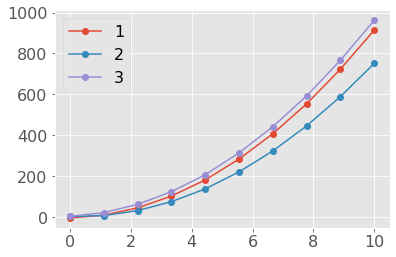

In [362]:
plt.figure()
plt.plot(Xs_full, Ys_full, 'o-')
plt.legend(['1','2','3'])

# lets fit each feature separately - unpooled model

In [363]:
Xs_full.shape

(10, 1)

In [364]:
Ys_full[:,0][:,np.newaxis].shape

(10, 1)

In [365]:
for i in range(Ys_full.shape[1]):
    print(i)

0
1
2


In [366]:
models = []
traces = []
for i in range(Ys_full.shape[1]):
    print(f"working: {i}")
    with pm.Model() as model:
        a = pm.Normal('a', mu=0, sd=10)
        b = pm.Normal('b', mu=0, sd=10)
        c = pm.Normal('c', mu=0, sd=10)
        sigma = pm.HalfNormal('sigma', sd=1)

        yhat = a + b*Xs_full + c*Xs_full**2
        y = pm.Normal('y', mu=yhat, sd=sigma, observed=Ys_full[:,i][:,np.newaxis]) # this [:,np.newaxis] is super important to get the correct inference

        # step = pm.Metropolis()
        step = pm.NUTS()
        trace = pm.sample(1000, tune=1000, cores=2, chains=2, step=step)
    
    models.append(model)
    traces.append(trace)

working: 0


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, c, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6915559163935059, but should be close to 0.8. Try to increase the number of tuning steps.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5449231855442833, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


working: 1


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, c, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6640330143023709, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


working: 2


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, c, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [367]:
As[0,0], Bs[0,0], Cs[0,0]

(-5, 2, 9)

In [368]:
traces[0]

<MultiTrace: 2 chains, 1000 iterations, 5 variables>

In [369]:
for trace in traces:
    print(az.summary(trace))

/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a     -3.987  0.536  -4.939   -2.955      0.037    0.026     215.0   206.0   
b      1.628  0.242   1.230    2.110      0.017    0.012     192.0   191.0   
c      9.020  0.023   8.976    9.061      0.002    0.001     199.0   199.0   
sigma  0.591  0.200   0.302    0.945      0.029    0.021      47.0    47.0   

       ess_bulk  ess_tail  r_hat  
a         142.0     403.0   1.02  
b         148.0     330.0   1.01  
c         174.0     299.0   1.01  
sigma      27.0      23.0   1.06  


/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a      2.879  0.512   1.988    3.887      0.025    0.018     412.0   412.0   
b     -5.308  0.229  -5.701   -4.852      0.012    0.008     393.0   393.0   
c      8.015  0.022   7.972    8.055      0.001    0.001     432.0   432.0   
sigma  0.623  0.192   0.308    0.964      0.016    0.012     137.0   137.0   

       ess_bulk  ess_tail  r_hat  
a         408.0     505.0   1.01  
b         391.0     542.0   1.01  
c         429.0     622.0   1.01  
sigma      67.0      23.0   1.01  


/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a      3.923  0.477   3.069    4.829      0.021    0.015     494.0   494.0   
b      5.677  0.226   5.243    6.088      0.011    0.008     440.0   438.0   
c      9.016  0.022   8.973    9.056      0.001    0.001     478.0   478.0   
sigma  0.611  0.178   0.338    0.915      0.010    0.007     303.0   303.0   

       ess_bulk  ess_tail  r_hat  
a         498.0     693.0   1.00  
b         443.0     559.0   1.01  
c         480.0     560.0   1.00  
sigma     206.0      89.0   1.01  


/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you 

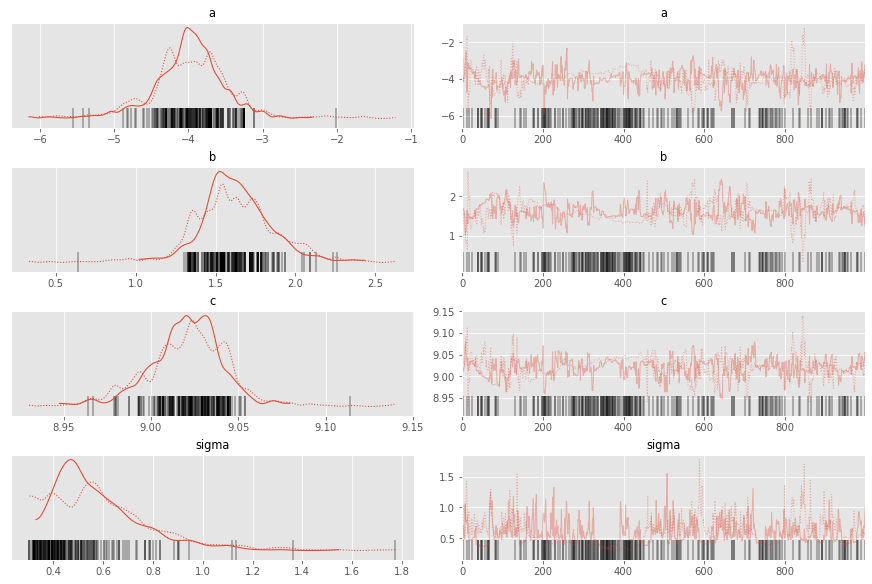

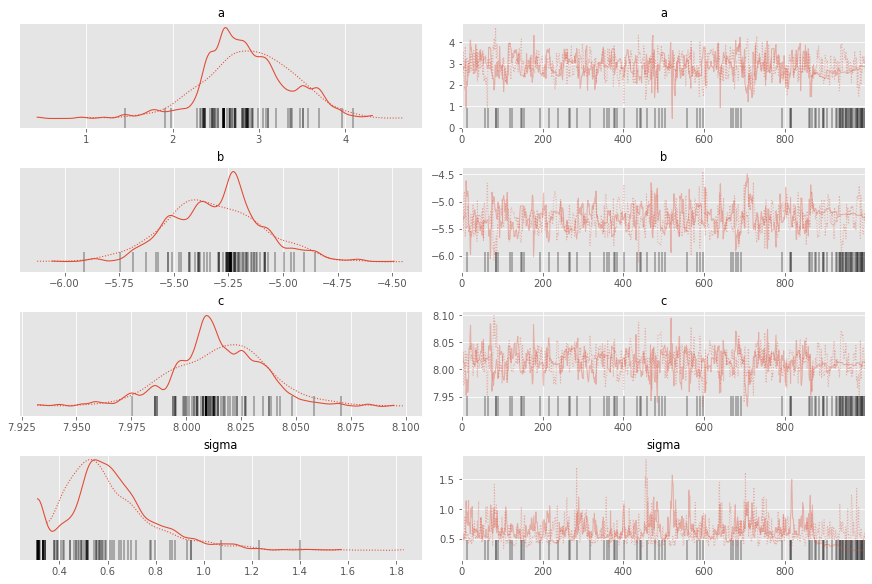

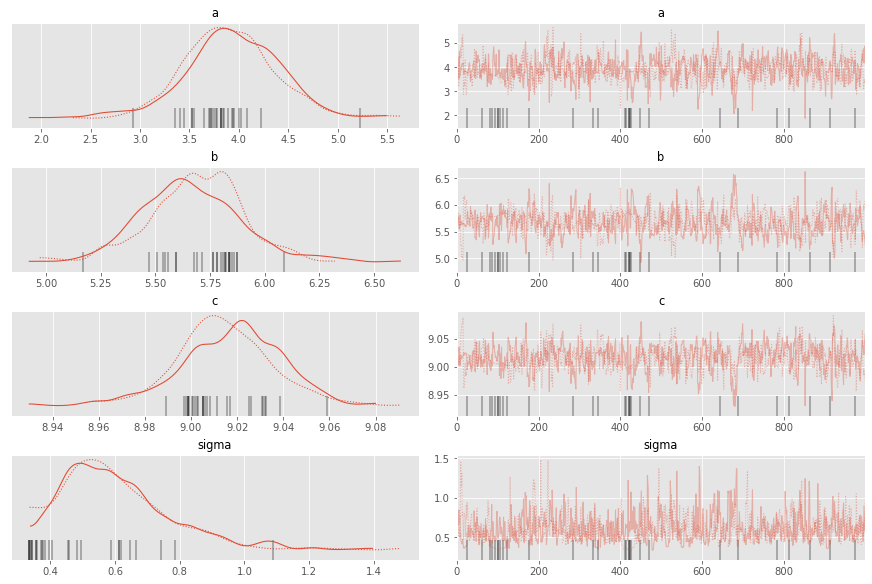

In [370]:
for trace in traces:
    az.plot_trace(trace)

In [371]:
np.vstack((As,Bs,Cs,np.repeat(noise_true,3)))

array([[-5,  2,  3],
       [ 2, -5,  6],
       [ 9,  8,  9],
       [ 1,  1,  1]])

In [372]:
print([numpy.quantile(trace['a'], 0.5) for trace in traces])
print([numpy.quantile(trace['b'], 0.5) for trace in traces])
print([numpy.quantile(trace['c'], 0.5) for trace in traces])
print([numpy.quantile(trace['sigma'], 0.5) for trace in traces])

[-3.97739964232918, 2.8573791957878067, 3.9128004445014666]
[1.6168906108566046, -5.30582599919035, 5.672508676056069]
[9.022140437731835, 8.014355209344544, 9.0163220063946]
[0.5513085392261544, 0.5853332045937438, 0.5768842866179484]


In [373]:
yhats=[]
for trace in traces:
    yhats.append(f(Xs_full, numpy.quantile(trace['a'], 0.5), numpy.quantile(trace['b'], 0.5), numpy.quantile(trace['c'], 0.5)))
yhats = np.array(yhats)
yhats = yhats[...,0].T

In [374]:
Ys_full.shape

(10, 3)

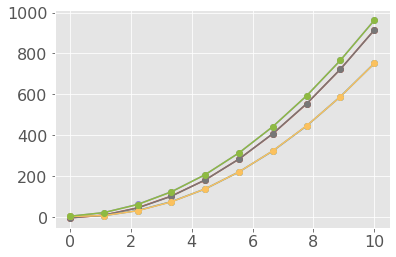

In [375]:
plt.figure()
plt.plot(Xs_full, Ys_full, 'o-')
plt.plot(Xs_full, yhats, 'o-')

In [376]:
np.mean(Ys_full**2-yhats**2, axis=0)

array([-25.34011221,  17.17113831,  12.2212008 ])

# that was three separate models now lets do it in one hierarchial model

In [377]:
# we need to change how to pass the data to the model
# instead of have a y-matrix that is (N, M)
# we need it to be (N*M, 1)

In [378]:
N = Ys_full.shape[0]

In [379]:
M = Ys_full.shape[1]

In [380]:
Ys = np.concatenate((Ys_full[:,0], Ys_full[:,1], Ys_full[:,2]))[:,np.newaxis]

In [381]:
Xs = np.concatenate((Xs_full,Xs_full,Xs_full))

In [382]:
Ys.shape

(30, 1)

In [383]:
Xs.shape

(30, 1)

In [384]:
# we need to index the model variables so that it knows which feature it belongs to
indexes = np.empty(shape=(N*M,), dtype=int)

In [385]:
indexes[:N]=0
indexes[N:2*N]=1
indexes[2*N:]=2

In [386]:
indexes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [387]:
np.where(indexes==0)[0].shape

(10,)

In [388]:
np.where(indexes==1)[0].shape

(10,)

In [389]:
np.where(indexes==2)[0].shape

(10,)

In [390]:
Ys[indexes==0]

array([[ -4.47532729],
       [  8.82829959],
       [ 44.74837469],
       [102.37854894],
       [181.19529724],
       [283.47971242],
       [407.32934396],
       [553.71770579],
       [723.57393038],
       [914.5527972 ]])

In [391]:
Ys_full[:,0]

array([ -4.47532729,   8.82829959,  44.74837469, 102.37854894,
       181.19529724, 283.47971242, 407.32934396, 553.71770579,
       723.57393038, 914.5527972 ])

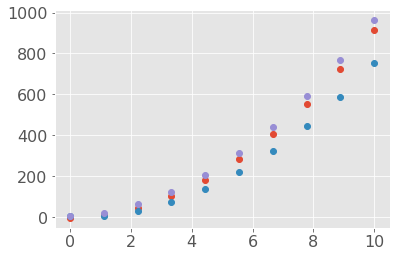

In [392]:
plt.figure()
plt.plot(Xs[indexes==0], Ys[indexes==0], 'o')
plt.plot(Xs[indexes==1], Ys[indexes==1], 'o')
plt.plot(Xs[indexes==2], Ys[indexes==2], 'o')

In [393]:
Xs.shape

(30, 1)

In [394]:
Ys.shape

(30, 1)

In [395]:
indexes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [396]:
with pm.Model() as model:
    # hyperparameters
    mu_a = pm.Normal('mu_a', mu=0., sd=100)
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=100)
#     mu_b = pm.Normal('mu_b', mu=0., sd=100)
#     sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)
#     mu_c = pm.Normal('mu_c', mu=0., sd=100)
#     sigma_c = pm.Uniform('sigma_c', lower=0, upper=100)

    # Common effects
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # Group effects
    # centred version
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=M)
#     non-centred version: https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/
#     a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=M)
#     a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    
    b = pm.Normal('b', mu=mu_a, sigma=sigma_a, shape=M)
#     b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=M)
#     b_offset = pm.Normal("b_offset", mu=0, sigma=1, shape=M)
#     b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
  
    c = pm.Normal('c', mu=mu_a, sigma=sigma_a, shape=M)
#     c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=M)
#     c_offset = pm.Normal("c_offset", mu=0, sigma=1, shape=M)
#     c = pm.Deterministic("c", mu_c + c_offset * sigma_c)
    
    
    d = pm.Normal('d', mu=mu_a, sigma=sigma_a, shape=M)
    
    # pay close attention to the shapes here
    # Xs[:,0] and Ys[:,0] so that they are (N*M,) and NOT (N*M,1)!
    # This was needed to make things work!
    yhat = a[indexes] + b[indexes]*Xs[:,0] + c[indexes]*Xs[:,0]**2 #+ d[indexes]*Xs[:,0]**3
    y = pm.Normal('y', mu=yhat, sd=sigma, observed=Ys[:,0])
    
    nsamples = 4000
    ntune = 10000
#     nsamples = 10000
#     ntune = 5000
#     step = pm.Metropolis()
    step = pm.NUTS()
    trace = pm.sample(nsamples, tune=ntune, cores=2, chains=2, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d, c, b, a, sigma, sigma_a, mu_a]


Sampling 2 chains for 10_000 tune and 4_000 draw iterations (20_000 + 8_000 draws total) took 66 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7129208161125957, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [397]:
az.summary(trace)

/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     3.451  2.219  -0.817    7.578      0.035    0.027    3920.0  3278.0   
a[0]    -4.019  0.437  -4.872   -3.210      0.008    0.006    2984.0  2918.0   
a[1]     2.948  0.448   2.080    3.769      0.009    0.006    2734.0  2695.0   
a[2]     3.942  0.436   3.084    4.719      0.007    0.005    3660.0  3660.0   
b[0]     1.648  0.205   1.258    2.038      0.004    0.003    2783.0  2773.0   
b[1]    -5.335  0.207  -5.711   -4.941      0.004    0.003    2591.0  2566.0   
b[2]     5.663  0.203   5.284    6.050      0.004    0.002    3333.0  3326.0   
c[0]     9.018  0.020   8.981    9.055      0.000    0.000    3077.0  3077.0   
c[1]     8.017  0.020   7.980    8.054      0.000    0.000    2913.0  2911.0   
c[2]     9.017  0.020   8.980    9.053      0.000    0.000    3671.0  3671.0   
d[0]     3.420  7.034  -9.271   16.835      0.117    0.091    3618.0  3015.0   
d[1]     3.312  7.096  -9.744   17.215      0.134    0.115    2794.0  1910.0   
d[2]     3.311  6.968 -10.554   15.910      0.112    0.091    3861.0  2910.0   
sigma_a  6.367  2.025   3.374    9.893      0.044    0.031    2071.0  2071.0   
sigma    0.555  0.095   0.399    0.726      0.002    0.002    1905.0  1905.0   

         ess_bulk  ess_tail  r_hat  
mu_a       3982.0    3416.0    1.0  
a[0]       2950.0    4608.0    1.0  
a[1]       2720.0    3432.0    1.0  
a[2]       3655.0    4407.0    1.0  
b[0]       2755.0    3608.0    1.0  
b[1]       2562.0    3524.0    1.0  
b[2]       3293.0    3734.0    1.0  
c[0]       3040.0    3812.0    1.0  
c[1]       2893.0    3785.0    1.0  
c[2]       3622.0    4248.0    1.0  
d[0]       3581.0    3503.0    1.0  
d[1]       3036.0    2149.0    1.0  
d[2]       3921.0    3169.0    1.0  
sigma_a    2255.0    2483.0    1.0  
sigma      1412.0     565.0    1.0

/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'d'}>,
        <AxesSubplot:title={'center':'d'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

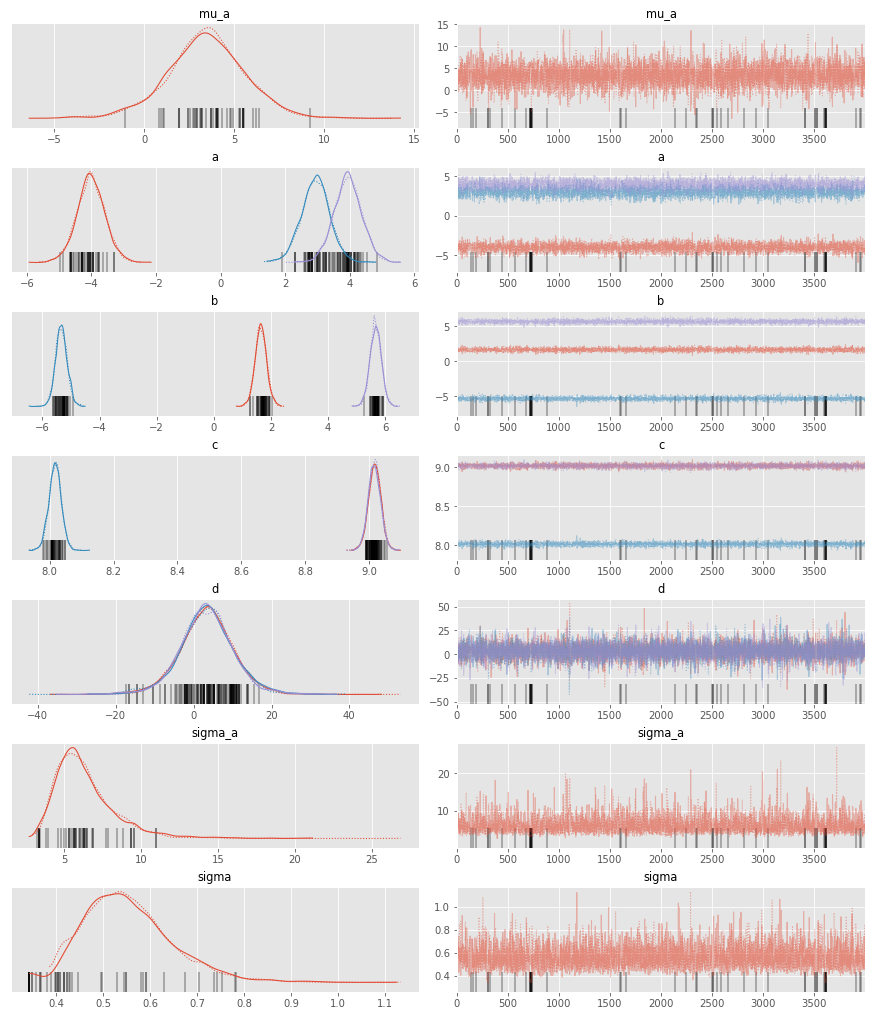

In [398]:
az.plot_trace(trace)

In [399]:
As

array([[-5,  2,  3]])

In [400]:
Bs

array([[ 2, -5,  6]])

In [401]:
Cs

array([[9, 8, 9]])

In [402]:
np.quantile(trace['a'],0.5,axis=0)

array([-4.02168146,  2.95512592,  3.94261075])

In [403]:
np.quantile(trace['b'],0.5,axis=0)

array([ 1.64631386, -5.33854344,  5.66090909])

In [404]:
np.quantile(trace['c'],0.5,axis=0)

array([9.01857561, 8.01727874, 9.01744006])

In [405]:
np.quantile(trace['sigma'],0.5,axis=0)

0.5427014415174153

In [406]:
np.quantile(trace['mu_a'],0.5,axis=0)

3.465202610571085

In [407]:
# plt.figure()
# plt.scatter(trace['b'][:,0], trace['sigma_b'])
# plt.yscale('log')

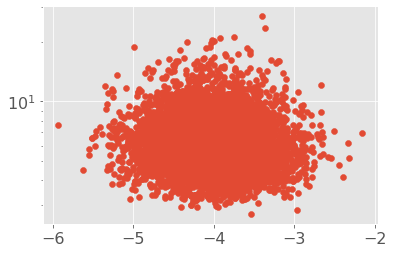

In [408]:
plt.figure()
plt.scatter(trace['a'][:,0], trace['sigma_a'])
plt.yscale('log')

In [409]:
# plt.figure()
# plt.scatter(trace['c'][:,0], trace['sigma_c'])
# plt.yscale('log')

In [410]:
colors = ['r', 'g', 'b']

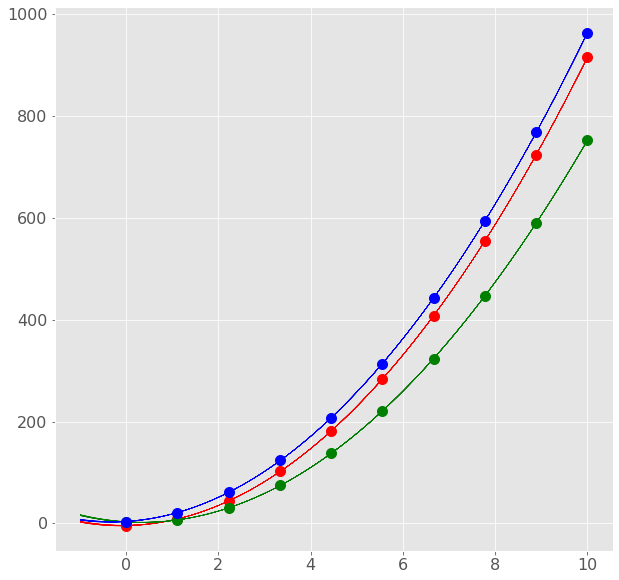

In [411]:
repeats = 100
nburn = 500
fig, ax = plt.subplots(figsize=(10, 10))
xfit = np.linspace(-1, 10, 100)

for i  in range(M):
    for j in range(repeats):
        s = trace[np.random.randint(nburn, nsamples)]
        yfit = s['a'][i] + s['b'][i] * xfit +  s['c'][i] * xfit**2
        ax.plot(xfit, yfit, "-", lw=0.1, color=colors[i])
    ax.plot(Xs[indexes == i], Ys[indexes == i], "o", color=colors[i], markersize=10)
    
plt.show()

# try gregs example

In [412]:
from pymc3 import Normal, Model
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 22
import seaborn

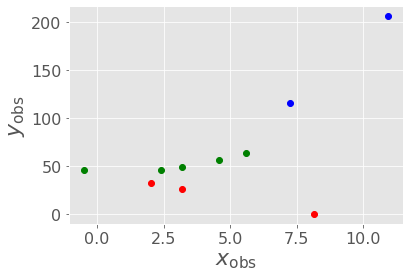

In [413]:
colors = ['r', 'g', 'b']
N_cars = 3
N_sightings = 10
idxs = np.array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2])

a_val = 45
mu_b_val = 0.1
sigma_b_val = 3
mu_c_val = 0.5
sigma_c_val = 0.5

b = np.random.normal(mu_b_val, sigma_b_val, N_cars)
c = np.random.normal(mu_c_val, sigma_c_val, N_cars)
xobs = np.random.uniform(0, 10, N_sightings) + np.random.normal(0, 1, N_sightings)
yobs = a_val + b[idxs]*xobs + c[idxs]*xobs**2

for i in range(N_cars):
    xobs_idv = xobs[idxs==i]
    yobs_idv = yobs[idxs==i]
    plt.plot(xobs_idv, yobs_idv, "o", color=colors[i])
    
plt.ylabel(r"$y_\mathrm{obs}$")
plt.xlabel(r"$x_\mathrm{obs}$")
plt.show()


In [414]:
b

array([-6.180669  , -1.46263651,  0.02449919])

In [415]:
c

array([0.08302873, 0.84917027, 1.34476529])

In [416]:
xobs

array([ 3.19722063,  2.03600493,  8.16422607, -0.50077979,  2.41611455,
        4.59662097,  5.6114053 ,  3.20283828, 10.94624064,  7.25612776])

In [417]:
yobs

array([2.60877755e+01, 3.27603078e+01, 7.38669440e-02, 4.59454141e+01,
       4.64232271e+01, 5.62188687e+01, 6.35311163e+01, 4.90263474e+01,
       2.06398198e+02, 1.15981531e+02])

In [418]:
idxs

array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2])

In [435]:
# with pm.Model() as hierarchical_model:
#     # hyperparameters
#     mu_b = pm.Normal('mu_b', mu=0., sd=100)
#     sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)
#     mu_c = pm.Normal('mu_c', mu=0., sd=100)
#     sigma_c = pm.Uniform('sigma_c', lower=0, upper=100)

#     # Common effects
#     a = pm.Normal('a', mu=45, sd=100, testval=10)   
#     eps = pm.Uniform('eps', lower=0, upper=10)
    
#     # Group effects
#     b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=N_cars)
#     c = pm.Normal('c', mu=mu_b, sd=sigma_b, shape=N_cars)

#     mu = a + b[idxs] * xobs + c[idxs] * xobs**2
    
#     # Likelihood (sampling distribution) of observations
#     Y_obs = Normal('Y_obs', mu=mu, sd=eps, observed=yobs)

# with pm.Model() as hierarchical_model:
#     # hyperparameters
#     mu_b = pm.Normal('mu_b', mu=0., sd=100)
#     sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)
#     mu_c = pm.Normal('mu_c', mu=0., sd=100)
#     sigma_c = pm.Uniform('sigma_c', lower=0, upper=100)

#     # Common effects
#     a = pm.Normal('a', mu=45, sd=100, testval=10)   
#     eps = pm.Uniform('eps', lower=0, upper=10)
    
#     # Group effects
#     b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=N_cars)
#     c = pm.Normal('c', mu=mu_c, sd=sigma_c, shape=N_cars)

#     mu = a + b[idxs] * xobs + c[idxs] * xobs**2
    
#     # Likelihood (sampling distribution) of observations
#     Y_obs = Normal('Y_obs', mu=mu, sd=eps, observed=yobs)

with pm.Model() as hierarchical_model:
    # hyperparameters
    mu_a = pm.Normal('mu_a', mu=0., sd=100)
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=100)
#     mu_b = pm.Normal('mu_b', mu=0., sd=100)
#     sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)
#     mu_c = pm.Normal('mu_c', mu=0., sd=100)
#     sigma_c = pm.Uniform('sigma_c', lower=0, upper=100)

    # Common effects

    eps = pm.Uniform('eps', lower=0, upper=10)
    
    # Group effects
#     a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=N_cars)  
#     b = pm.Normal('b', mu=mu_a, sd=sigma_a, shape=N_cars)
#     c = pm.Normal('c', mu=mu_a, sd=sigma_a, shape=N_cars)
#     b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=N_cars)
#     c = pm.Normal('c', mu=mu_c, sd=sigma_c, shape=N_cars)

    # non-centred parameterisation
    a_offset = pm.Normal("a_offset", mu=0, sigma=1, shape=N_cars)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    b_offset = pm.Normal("b_offset", mu=0, sigma=1, shape=N_cars)
    b = pm.Deterministic("b", mu_a + b_offset * sigma_a)
    c_offset = pm.Normal("c_offset", mu=0, sigma=1, shape=N_cars)
    c = pm.Deterministic("c", mu_a + c_offset * sigma_a)

    mu = a[idxs] + b[idxs] * xobs + c[idxs] * xobs**2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=eps, observed=yobs)

In [436]:
nsamples = 40000
ntune = 10000
with hierarchical_model:
#     step = pm.Metropolis()
    step = pm.NUTS()
    hierarchical_trace = pm.sample(nsamples, tune=ntune, cores=4, chains=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_offset, b_offset, a_offset, eps, sigma_a, mu_a]


Sampling 4 chains for 10_000 tune and 40_000 draw iterations (40_000 + 160_000 draws total) took 749 seconds.
There were 21877 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42912440430696497, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20839 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5629574737472984, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22495 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5521975945791424, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23397 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5094734639063825, but s

In [441]:
az.summary(hierarchical_trace)

/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_a          6.421   5.181  -4.189   13.990      0.888    0.633      34.0   
a_offset[0]   0.607   0.728  -0.902    1.833      0.124    0.088      35.0   
a_offset[1]   2.215   0.601   1.215    3.389      0.131    0.097      21.0   
a_offset[2]   0.039   0.827  -1.552    1.627      0.133    0.095      39.0   
b_offset[0]   0.122   0.521  -0.948    1.122      0.071    0.051      53.0   
b_offset[1]  -0.403   0.450  -1.291    0.309      0.073    0.052      38.0   
b_offset[2]   0.112   0.459  -0.683    1.014      0.065    0.080      49.0   
c_offset[0]  -0.559   0.387  -1.232    0.120      0.067    0.048      33.0   
c_offset[1]  -0.426   0.370  -1.080    0.183      0.060    0.043      38.0   
c_offset[2]  -0.408   0.359  -1.072    0.182      0.062    0.044      33.0   
sigma_a      15.732   5.040   7.315   23.982      1.274    0.987      16.0   
eps           6.857   1.896   3.225    9.998      0.653    0.479       8.0   
a[0]         16.226  11.146  -5.097   36.108      1.622    1.168      47.0   
a[1]         39.565   6.187  27.714   51.500      0.858    0.610      52.0   
a[2]          7.753  14.399 -17.525   35.457      2.585    1.846      31.0   
b[0]          8.296   5.875  -1.882   20.287      0.737    0.557      63.0   
b[1]          0.619   3.936  -6.588    8.019      0.339    0.261     135.0   
b[2]          8.372   4.249   1.008   16.802      0.629    0.470      46.0   
c[0]         -1.262   0.599  -2.482   -0.215      0.068    0.050      79.0   
c[1]          0.664   0.722  -0.733    1.951      0.051    0.036     198.0   
c[2]          0.894   0.338   0.250    1.517      0.040    0.029      70.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
mu_a           34.0      33.0      17.0   1.18  
a_offset[0]    35.0      28.0     284.0   1.09  
a_offset[1]    20.0      23.0      84.0   1.15  
a_offset[2]    39.0      35.0     265.0   1.07  
b_offset[0]    53.0      49.0      75.0   1.12  
b_offset[1]    38.0      40.0     137.0   1.08  
b_offset[2]    17.0      54.0      51.0   1.13  
c_offset[0]    33.0      31.0      16.0   1.16  
c_offset[1]    38.0      41.0      93.0   1.14  
c_offset[2]    33.0      36.0      96.0   1.14  
sigma_a        14.0      23.0      13.0   1.17  
eps             8.0       9.0      14.0   1.35  
a[0]           46.0      44.0      41.0   1.11  
a[1]           52.0      53.0     189.0   1.06  
a[2]           31.0      30.0     104.0   1.09  
b[0]           56.0      58.0      70.0   1.11  
b[1]          114.0     130.0     338.0   1.04  
b[2]           42.0      49.0      86.0   1.11  
c[0]           72.0      74.0     112.0   1.10  
c[1]          198.0     189.0     801.0   1.04  
c[2]           70.0      72.0     369.0   1.06

/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'a_offset'}>,
        <AxesSubplot:title={'center':'a_offset'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>],
       [<AxesSubplot:title={'center':'c_offset'}>,
        <AxesSubplot:title={'center':'c_offset'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>]], dtype=object)

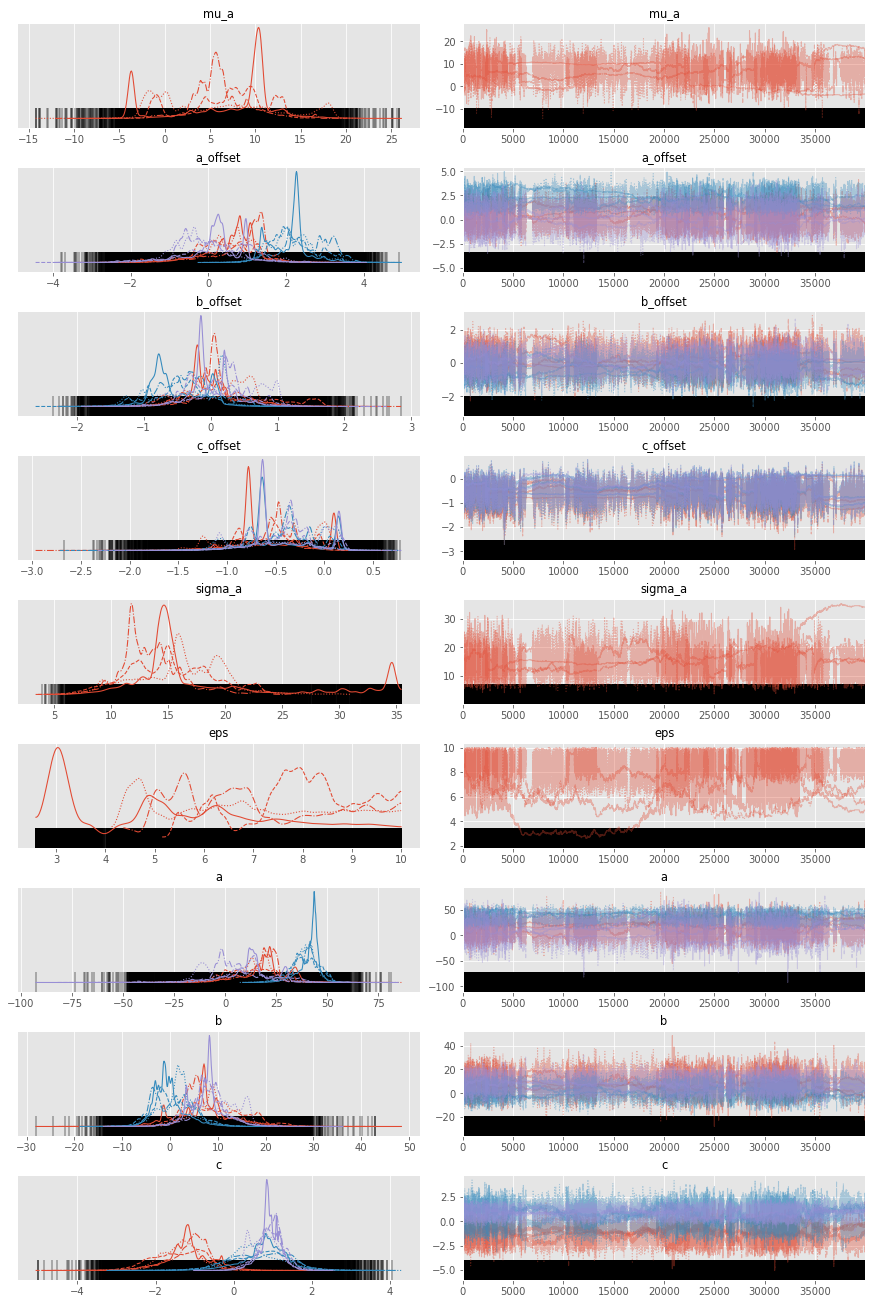

In [442]:
az.plot_trace(hierarchical_trace)

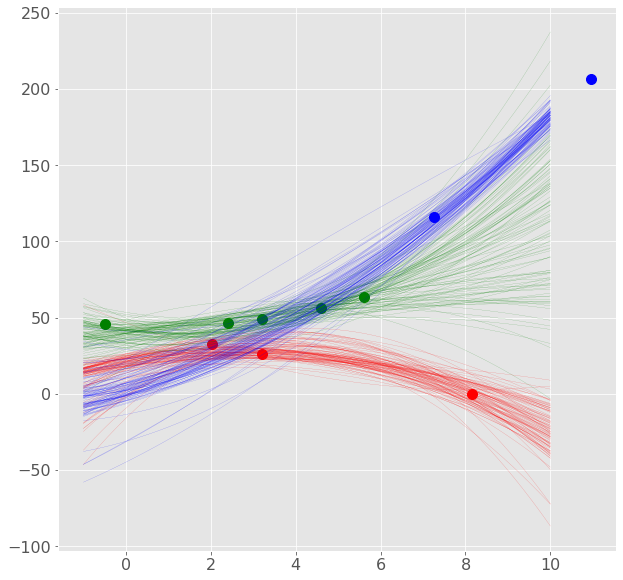

In [449]:
repeats = 100
# nburn = 39000
nburn = 2000
fig, ax = plt.subplots(figsize=(10, 10))
xfit = np.linspace(-1, 10, 100)

for i  in range(N_cars):
    for j in range(repeats):
        s = hierarchical_trace[np.random.randint(nburn, nsamples)]
        yfit = s['a'][i] + s['b'][i] * xfit+  s['c'][i] * xfit**2
        ax.plot(xfit, yfit, "-", lw=0.1, color=colors[i])
    ax.plot(xobs[idxs == i], yobs[idxs == i], "o", color=colors[i], markersize=10)
    
plt.show()

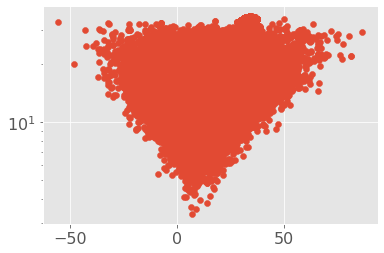

In [444]:
plt.figure()
plt.scatter(hierarchical_trace['a'][:,0], hierarchical_trace['sigma_a'])
plt.yscale('log')